### HW4, Jordan Gittleman

In [52]:
import os
import cv2
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from collections import namedtuple
import math
import gtsam
import gtsam.utils.plot
import itertools



In [53]:
siftPts = namedtuple('siftPts', 'k d')
def siftDC(img):
    img=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)
    # take in source and destinatition photos and outputs sift detected key points and computed descriptors as an array
    sift = cv2.SIFT_create(nfeatures=4000,
                                   nOctaveLayers=6,
                                   contrastThreshold=0.025,
                                   sigma=1.5) #create our detector
    keypoints, descriptors = sift.detectAndCompute(img,None) # detect keypoints and compute descriptors

    return siftPts(keypoints,descriptors)

In [54]:
def matchMaker(d1,d2,pts):
    # takes in keypoints and descriptors for two images and returns a sorted index of matches using bfmatcher
    # bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

    # matches = bf.match(d1,d2)
    # matches = sorted(matches, key = lambda x:x.distance)

    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(d1,d2, k=2)
    xmatches = bf.knnMatch(d2,d1, k=2)

    # Apply ratio test
    good = []
    goodmatch = 0
    ratio = 0.01
    while goodmatch <= pts:
        for m in matches:
            if m[0].distance < ratio*m[1].distance :
                good.append(m[0])
                goodmatch +=1
        ratio += .05

    good = sorted(good, key = lambda x:x.distance)

    return matches, good

In [55]:

def getFun(dest_kp, src_kp,good): # find fundamental matrix, works in much the same way as finding H

    dest = np.array([dest_kp[mat.queryIdx].pt for mat in good])
    src = np.array([src_kp[mat.trainIdx].pt for mat in good])
    p = np.array([0,0,0,0,0,0,0,0,1])    

    F, mask = cv2.findFundamentalMat(dest,src,cv2.FM_RANSAC)
    return F, mask, src, dest

 


In [56]:
# Lets start by making a function to load in our images and detect features, storing what we find for later
Graphbin = namedtuple('Graphbin', 'im pts')
def gtloader(folder):
    im_paths = []
    for file in os.listdir(folder):
        if ".png" in file:
            im_paths.append(os.path.join(folder,file))
            # print(im_paths)

    # now lets find features for each image and put them in a list
    imgsAndPts=[]
    im_paths.sort()
    for image in im_paths:
        img = cv2.imread(image)
        img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (0,0), fx=1, fy=1)
        imgsAndPts.append(Graphbin(img,siftDC(img)))

    im_height, im_width = img.shape[:2]
    # get center point of image, this is our "pose"
    cam_matrix = np.array([[1, 0, im_width/2], 
                          [0, 1, im_height/2],
                          [0, 0, 1]])

    return imgsAndPts, cam_matrix

In [57]:
buddha,cam_matrix=gtloader("./buddha_images")


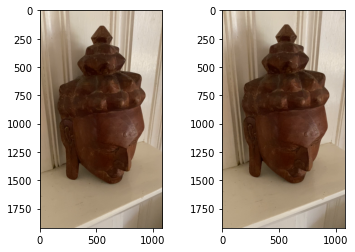

In [ ]:
plt.subplot(121), plt.imshow(buddha[4].im)
plt.subplot(122), plt.imshow(buddha[5].im)
plt.show()

In [ ]:
matches, good = matchMaker(buddha[1].pts.d,buddha[2].pts.d,500)
imgLeft = buddha[1].im
imgRight = buddha[2].im

F, mask, ptsLeft, ptsRight= getFun(buddha[1].pts.k,buddha[2].pts.k,good)
print(F)
ptsLeft = np.int32(ptsLeft)
ptsRight = np.int32(ptsRight)
# We select only inlier points
ptsLeft = ptsLeft[mask.ravel() == 1]
ptsRight = ptsRight[mask.ravel() == 1]

[[-1.72998736e-07 -3.53425706e-06  5.59279736e-03]
 [ 2.57045415e-06  3.08850905e-07  2.58121019e-02]
 [-5.42634073e-03 -2.72500202e-02  1.00000000e+00]]


In [ ]:
def drawlines(img1, img2, lines, pts1, pts2):

    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    r, c = img1.shape
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
      
    for r, pt1, pt2 in zip(lines, pts1, pts2):
          
        color = tuple(np.random.randint(0, 255,
                                        3).tolist())
          
        x0, y0 = map(int, [0, -r[2] / r[1] ])
        x1, y1 = map(int, [c, -(r[2] + r[0] * c) / r[1] ])
          
        img1 = cv2.line(img1, 
                        (x0, y0), (x1, y1), color, 1)
        img1 = cv2.circle(img1,
                          tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, 
                          tuple(pt2), 5, color, -1)
    return img1, img2

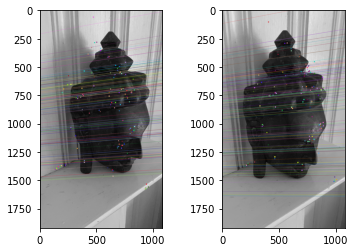

In [ ]:
# Find epilines corresponding to points
# in right image (second image) and
# drawing its lines on left image
linesLeft = cv2.computeCorrespondEpilines(ptsRight.reshape(-1,
                                                           1,
                                                           2),
                                          2, F)
linesLeft = linesLeft.reshape(-1, 3)
img5, img6 = drawlines(imgLeft, imgRight, 
                       linesLeft, ptsLeft,
                       ptsRight)
   
# Find epilines corresponding to 
# points in left image (first image) and
# drawing its lines on right image
linesRight = cv2.computeCorrespondEpilines(ptsLeft.reshape(-1, 1, 2), 
                                           1, F)
linesRight = linesRight.reshape(-1, 3)
  
img3, img4 = drawlines(imgRight, imgLeft, 
                       linesRight, ptsRight,
                       ptsLeft)
   
plt.subplot(121), plt.imshow(img5)
plt.subplot(122), plt.imshow(img3)
plt.show()

In [ ]:
#steps: fund mat -> essential -> recover pose -> projection mat -> triangulate pts
essential=cam_matrix.transpose()@F@cam_matrix

essential=cv2.findEssentialMat(ptsLeft,ptsRight,cam_matrix)

In [ ]:
print(essential[0])

[[ 4.11146655e-06 -4.39507497e-04 -2.37332336e-01]
 [ 4.27626965e-04  2.80416206e-06 -6.66087966e-01]
 [ 2.25549857e-01  6.70169434e-01 -8.37621613e-06]]


In [ ]:
pts, R, t, mask = cv2.recoverPose(essential[0], ptsLeft, ptsRight)

In [ ]:
print(t)

[[ 9.41990625e-01]
 [-3.35638613e-01]
 [ 6.19176444e-04]]


In [ ]:
def PlotCamera(R,t,ax,scale=.5,depth=.5,faceColor='grey'):
    C = -t #camera center (in world coordinate system)

    #Generating camera coordinate axes
    axes = np.zeros((3,6))
    axes[0,1], axes[1,3],axes[2,5] = 1,1,1
    
    #Transforming to world coordinate system 
    axes = R.T.dot(axes)+C[:,np.newaxis]

    #Plotting axes
    ax.plot3D(xs=axes[0,:2],ys=axes[1,:2],zs=axes[2,:2],c='r')
    ax.plot3D(xs=axes[0,2:4],ys=axes[1,2:4],zs=axes[2,2:4],c='g')
    ax.plot3D(xs=axes[0,4:],ys=axes[1,4:],zs=axes[2,4:],c='b')

    #generating 5 corners of camera polygon 
    pt1 = np.array([[0,0,0]]).T #camera centre
    pt2 = np.array([[scale,-scale,depth]]).T #upper right 
    pt3 = np.array([[scale,scale,depth]]).T #lower right 
    pt4 = np.array([[-scale,-scale,depth]]).T #upper left
    pt5 = np.array([[-scale,scale,depth]]).T #lower left
    pts = np.concatenate((pt1,pt2,pt3,pt4,pt5),axis=-1)
    
    #Transforming to world-coordinate system
    pts = R.T.dot(pts)+C[:,np.newaxis]
    ax.scatter3D(xs=pts[0,:],ys=pts[1,:],zs=pts[2,:],c='k')
    
    #Generating a list of vertices to be connected in polygon
    verts = [[pts[:,0],pts[:,1],pts[:,2]], [pts[:,0],pts[:,2],pts[:,-1]],
            [pts[:,0],pts[:,-1],pts[:,-2]],[pts[:,0],pts[:,-2],pts[:,1]]]
    
    #Generating a polygon now..
    ax.add_collection3d(Poly3DCollection(verts, facecolors=faceColor,
                                         linewidths=1, edgecolors='k', alpha=.25))

[0 0 0]


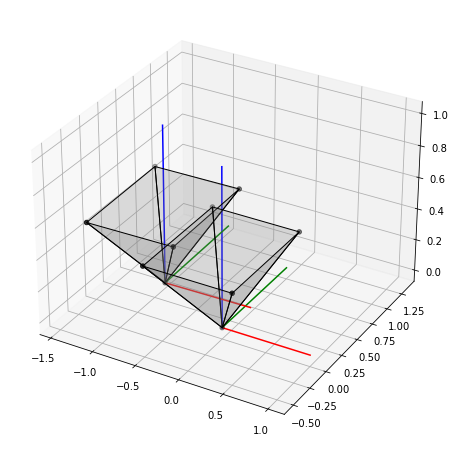

In [ ]:
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection='3d')
#for initial camera
R1=np.eye(3)
t1=np.array([0,0,0])
print(t1)
PlotCamera(R1,t1,ax)
PlotCamera(R,t.T[0],ax)

In [ ]:
def turtlechip():
    fig = plt.figure(figsize=(8,8))

    ax = fig.add_subplot(111, projection='3d')
    #for initial camera
    R1=np.eye(3)
    t1=np.array([0,0,0])
    PlotCamera(R1,t1,ax)

    for i in range(len(buddha)-1):
        print(i)
        matches, good = matchMaker(buddha[i].pts.d,buddha[i+1].pts.d,4000)
        imgLeft = buddha[i].im
        imgRight = buddha[i+1].im


        F, mask, ptsLeft, ptsRight= getFun(buddha[i].pts.k,buddha[i+1].pts.k,good)
        ptsLeft = np.int32(ptsLeft)
        ptsRight = np.int32(ptsRight)
        # We select only inlier points
        ptsLeft = ptsLeft[mask.ravel() == 1]
        ptsRight = ptsRight[mask.ravel() == 1]
        essential=cv2.findEssentialMat(ptsLeft,ptsRight,cam_matrix)
        print(essential[0])
        pts, R, t, mask = cv2.recoverPose(essential[0], ptsLeft, ptsRight)
        # R1=np.matmul(R1,R)
        t1=t1+t.T[0]
        #for initial camera
        PlotCamera(R1,t1,ax)

0
[[ 5.63963761e-04 -3.40895139e-02  2.83375380e-01]
 [ 3.42035171e-02  3.47860303e-04 -6.46942869e-01]
 [ 2.94129277e-01 -6.42120565e-01  2.28929828e-04]]
1
[[-9.90698055e-06  4.48403359e-04  2.45055721e-01]
 [-4.58706422e-04 -4.30197906e-06  6.63285743e-01]
 [-2.36261861e-01 -6.66468033e-01 -2.20997587e-06]]
2
[[ 1.71794199e-05 -9.28518181e-04 -1.68386291e-01]
 [ 8.97111305e-04  2.13298563e-05 -6.86764334e-01]
 [ 1.50063839e-01  6.90999264e-01 -1.00527320e-05]]
3
[[-1.07101795e-05  5.08486273e-04  9.08461996e-02]
 [-5.29224321e-04 -1.33783681e-05 -7.01246524e-01]
 [-1.09283100e-01  6.98610725e-01  3.24952151e-06]]
4
[[-2.54231270e-05 -6.14509749e-04 -5.20415298e-01]
 [ 6.68158203e-04 -1.17908658e-05  4.78714423e-01]
 [ 5.26900577e-01 -4.71566935e-01 -5.47171472e-05]]
5
[[-1.57088456e-05  2.90904834e-04 -1.11272728e-01]
 [-3.23388618e-04 -1.55043708e-05 -6.98296696e-01]
 [ 8.57050178e-02  7.01893557e-01 -8.76568338e-06]]
6
[[-1.08424000e-07  3.83609686e-04  2.24960742e-01]
 [-3.999124

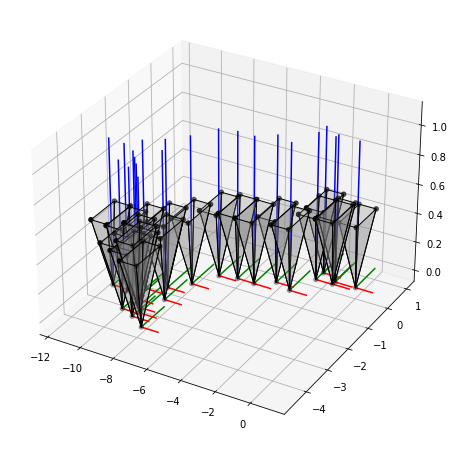

In [ ]:
pts=turtlechip()

In [ ]:
def GetTriangulatedPts(img1pts,img2pts,K,R,t): 
    img1ptsHom = cv2.convertPointsToHomogeneous(img1pts)[:,0,:]
    img2ptsHom = cv2.convertPointsToHomogeneous(img2pts)[:,0,:]

    img1ptsNorm = (np.linalg.inv(K).dot(img1ptsHom.T)).T
    img2ptsNorm = (np.linalg.inv(K).dot(img2ptsHom.T)).T

    img1ptsNorm = cv2.convertPointsFromHomogeneous(img1ptsNorm)[:,0,:]
    img2ptsNorm = cv2.convertPointsFromHomogeneous(img2ptsNorm)[:,0,:]

    pts4d = cv2.triangulatePoints(np.eye(3,4),np.hstack((R,t)),img1ptsNorm.T,img2ptsNorm.T)
    pts3d = cv2.convertPointsFromHomogeneous(pts4d.T)[:,0,:]

    return pts3d

In [ ]:
ptsv2=GetTriangulatedPts(ptsLeft,ptsRight,cam_matrix,R,t)

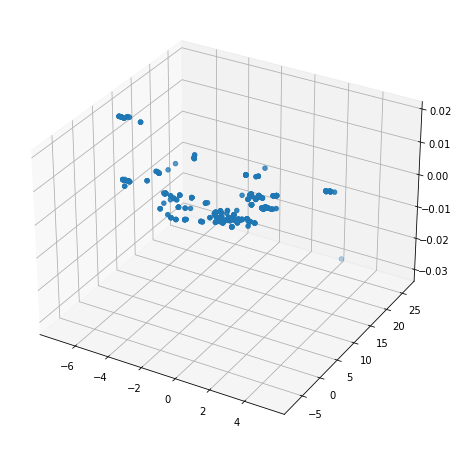

In [ ]:
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(ptsv2[:,0], ptsv2[:,1], ptsv2[:,2])